In [36]:
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
from lib.w3schools import checkInside, Point
from paddleocr import PaddleOCR
from copy import copy

OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

SUBTRACTION = "-"
MULTIPLICATION = "*"
DIVISION = "/"
ADDITION = "+"
CONSTANT = "_"

def imshow(img):
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

""" Fine tune these values for different quality screenshots. """
def getblur(game_size):
    match game_size:
        case 3|4|5:
            return (41, 41)
        case 6|7|8:
            return (37, 37)
        case 9:
            return (33, 33)

<hr>

<i>Crop the image by its largest contour.</i> 

After this step, the image should have an even border.

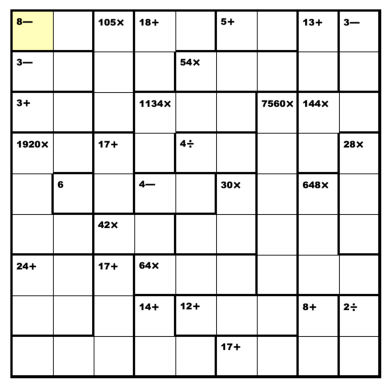

In [41]:
# Read the input image and perform cropping
og_img = cv2.imread('kenken.png')
gray = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, getblur(GAME_SIZE), 0)
ret, thresh = cv2.threshold(blur,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

outer_border = contours[1]
x, y, w, h = cv2.boundingRect(outer_border)
img = og_img[y:y+h, x:x+w]

imshow(img)

<hr>

<i>Determine the game size.</i>

If the determined game size is not accurate, manually set it.

In [37]:
# calculate game size from the contours
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,150,255,0)
new_contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for contour in sorted(new_contours, key=cv2.contourArea, reverse=True):
    x, y, w, h = cv2.boundingRect(contour)
    ratio = len(img) // min(w, h)
    if ratio == 1:
        continue
    else:
        GAME_SIZE = ratio
        break

print(f"The game size is {GAME_SIZE}.")

# GAME_SIZE =    # MNAUALLY SET IT HERE

The game size is 9.


<hr>

<i>Find all the blocks in the image.</i>

After this step, the outputted image should have green outlines wherever the major blocks are.

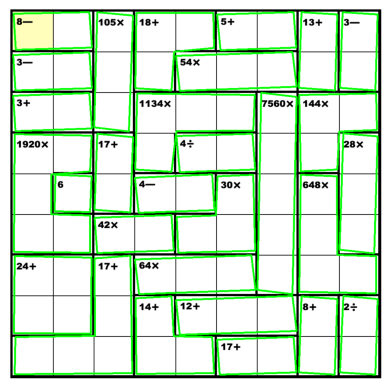

In [39]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, getblur(GAME_SIZE), 0)
ret, thresh = cv2.threshold(blur,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# get dark-squared contours
filtered = []; shapes = []
for contour in contours:
    epsilon = 0.02*cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) >= 4:
        x, y, w, h = cv2.boundingRect(contour)
        if min(w, h) > len(img) / 10:       # assures that no numbered contours are interpreted
            filtered.append(contour)
            shapes.append(approx)

# draw the contour on the input image
newimg = cv2.drawContours(img.copy(), shapes, -1, (0,255,0), 3)

# display the image with drawn contours and approximate contours
imshow(newimg)

<hr>

<i>Determine the operations within each square, preparing it for solving.</i>

If something is going wrong, check the printed result and assure it is consistent with the image.

In [40]:
relations = []
box_size = len(img) / GAME_SIZE 

def process(text: str):
    text = text.replace(' ', '')    # remove shapes
    text = text.lower()             # standardize style
    text = text.strip()             # remove any whitespace
    return text

for approx in shapes:
    approx = list(map(lambda arr: list(map(lambda x: round(x/box_size), arr[0])), approx))
    points = list(map(lambda x: Point(*x), approx))
    x, y, w, h = cv2.boundingRect(np.array(approx))
    rel = []
    for xx in np.arange(start=x+0.5, stop=x+w+0.5, step=1):
        for yy in np.arange(start=y+0.5, stop=y+h+0.5, step=1):
            if checkInside(points, len(points), Point(xx, yy)):
                rel.append(Point(xx-0.5, yy-0.5))
    relations.append(rel)

operations = []
for i in range(len(relations)):
    rel = relations[i]
    operation = {
        "result": None,
        "operand": None,
        "squares": []
    }
    for point in rel:      # determine which point in the relation has the operation indicator
        cropped_img = img[int(yy:=point.y*box_size):int(yy+box_size), int(xx:=point.x*box_size):int(xx+box_size)]
        if (text:=OCR.ocr(cropped_img, cls=True)) != [[]]:
            text = process(text[0][0][1][0])     # get prediction and process it
            """ By this step, <text> should be a string like this: "17+", "14x", "3:", etc. """
            if "+" in text:
                operation["operand"] = ADDITION
                operation["result"] = int(text.replace("+", ""))
            elif ":" in text:
                operation["operand"] = DIVISION
                operation["result"] = int(text.replace(":", ""))
            elif "x" in text:
                operation["operand"] = MULTIPLICATION
                operation["result"] = int(text.replace("x", ""))
            elif any([s in text for s in ["-", "—", "_"]]):
                operation["operand"] = SUBTRACTION
                operation["result"] = int(re.sub(r"[\_\-\—]+", "", text))
            else:   # likely fully empty
                operation["result"] = int(text)
                match len(rel):
                    case 2: 
                        operation["operand"] = SUBTRACTION
                    case 1:
                        operation["operand"] = CONSTANT
                    case _:
                        raise Exception("Invalid pattern detected.")
            operation["squares"] = copy(rel)
            break
    operations.append(operation)

print(*operations, sep="\n")

{'result': 17, 'operand': '+', 'squares': [(5.0, 8.0), (6.0, 8.0)]}
{'result': 2, 'operand': '/', 'squares': [(8.0, 7.0), (8.0, 8.0)]}
{'result': 8, 'operand': '+', 'squares': [(7.0, 7.0), (7.0, 8.0)]}
{'result': 12, 'operand': '+', 'squares': [(4.0, 7.0), (5.0, 7.0), (6.0, 7.0)]}
{'result': 14, 'operand': '+', 'squares': [(3.0, 7.0), (3.0, 8.0), (4.0, 8.0)]}
{'result': 64, 'operand': '*', 'squares': [(3.0, 6.0), (4.0, 6.0), (5.0, 6.0)]}
{'result': 17, 'operand': '+', 'squares': [(0.0, 8.0), (1.0, 8.0), (2.0, 6.0), (2.0, 7.0), (2.0, 8.0)]}
{'result': 24, 'operand': '+', 'squares': [(0.0, 6.0), (0.0, 7.0), (1.0, 6.0), (1.0, 7.0)]}
{'result': 42, 'operand': '*', 'squares': [(2.0, 5.0), (3.0, 5.0)]}
{'result': 648, 'operand': '*', 'squares': [(7.0, 4.0), (7.0, 5.0), (7.0, 6.0), (8.0, 6.0)]}
{'result': 30, 'operand': '*', 'squares': [(4.0, 5.0), (5.0, 4.0), (5.0, 5.0)]}
{'result': 4, 'operand': '-', 'squares': [(3.0, 4.0), (4.0, 4.0)]}
{'result': 6, 'operand': '_', 'squares': [(1.0, 4.0)]}